# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

import IPython
from IPython.display import Image
from pathlib import Path

In [ ]:
ROOT_PATH = Path(r"/content/drive/MyDrive/capstone/dataset/Echos")
SAVE_PATH = Path(r"/content/drive/MyDrive/capstone/dataset/Processed_with_pydicom")
DATASET_PATH = Path(r"/content/drive/MyDrive/capstone/dataset")
MAX_SEQ_LENGTH = 28 # the length of the frames in every video
NUM_FEATURES = 1024 # the nums of features extracted with CNN
IMG_SIZE = 224

# Load video as Numpy array

```func:```
- **crop_center_square**: crop the image
- **uniform_frames**: uniform the number of frames in each video
- **load_video**: load video as processed numpy array  

In [ ]:
def crop_center_square(img):
  '''
  crop the image
  Params: image_array: array of one frame
  Return: cropped_array: array of cropped image
  '''
  h,w =  img.shape[:2]
  square_w = min(h,w)   # take the shorter as the length of the square
  start_x = w//2 - square_w//2
  end_x = start_x + square_w
  start_y = h//2 - square_w//2
  end_y = start_y + square_w
  result = img[start_y+70:end_y-50,start_x:end_x]
  return result

In [ ]:
def uniform_frames(MAX_SEQ_LENGTH, video_arr):
  '''
  uniform the number of frames in each video.
  Params: MAX_SEQ_LENGTH: maximum allowed number of frames, video_arr: array of videos, where each video is an array of frames
  Return: array of uniformed videos, where each video is an array of frames with a length of MAX_SEQ_LENGTH.
  '''
  frames_count = len(video_arr)
  if frames_count < MAX_SEQ_LENGTH: 
      diff = MAX_SEQ_LENGTH - frames_count 
      multiplier = diff//frames_count + 1  
      padding = video_arr
      for _ in range(multiplier):
          video_arr = np.concatenate((video_arr, padding))    
  video_arr = video_arr[:MAX_SEQ_LENGTH]
  return video_arr


In [ ]:
import random

def load_video(video_path, seed_value):
    '''
    load video as processed numpy array 
    params: video_path: the path of a video which needs to be transfered into array format
    return: the array of processed video 
    '''

    frames = np.load(video_path).astype('float32')
    res = []

    for data in frames:
        
        rng = np.random.RandomState(seed_value)

        data = crop_center_square(data)

        scale_factor = rng.uniform(0.6, 1.5)
        scaled_size = (int(data.shape[1] * scale_factor), int(data.shape[0] * scale_factor))
        random_offset = (rng.randint(-10, 10), rng.randint(-10, 10))

        # 缩放图像
        scaled_data = cv2.resize(data, scaled_size, interpolation=cv2.INTER_NEAREST)

        center = (data.shape[1] // 2 + random_offset[0], data.shape[0] // 2 + random_offset[1])
        data = cv2.getRectSubPix(scaled_data, scaled_size, center)
        data = cv2.resize(data,(224,224))



        img = data.copy()
        img[img<=95] = 0
        img[img>150] = 255
        img = ((img - img.min()) / (img.max()- img.min())) * 255
        img = img.astype('uint8')
        img = cv2.equalizeHist(img)
        alpha = 0.8
        beta = 0.1  # 图像的最小亮度值为50
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        angle = rng.randint(-30, 30)
        M = cv2.getRotationMatrix2D((224/2, 224/2), angle, 1)
        img = cv2.warpAffine(img, M, (224, 224))


        color_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        color_img[:, :, 0] = img
        color_img[:, :, 1] = img
        color_img[:, :, 2] = img

        res.append(color_img)
    
    images = uniform_frames(28,res)
    images = np.array(images)
    return images


test on single video

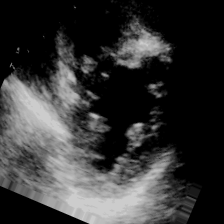

In [ ]:
frames = load_video('/content/drive/MyDrive/capstone/dataset/Processed_with_pydicom/1/1285/23.npy',seed_value = 42)

frames = frames.astype(np.uint8)

imageio.mimsave("animation.gif", frames, fps=10)
Image(filename='animation.gif',embed=True)

# Feature extaction 

```func:```  

**build_feature_extractor**: the feature extractor  
**extract_feature**: extract the features of data (data in the paths)

#### build_feature_extractor

**ResNet50**

In [ ]:
def build_feature_extractor_ResNet():
  '''
  the feature extractor built by resnet50
  return: the extractor
  '''
  base_model = ResNet50(weights='imagenet', include_top=False, pooling = 'avg') # 加载 ResNet50 模型，不包括顶层的全连接层
  x = base_model.output
  # x = GlobalAveragePooling2D()(x) # pool(avg)
  predictions = Dense(1024, activation='relu')(x) # 添加全连接层和输出层
  model = Model(inputs=base_model.input, outputs=predictions)# 构建完整的模型
  return model
feature_extractor_ResNet = build_feature_extractor_ResNet()

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
feature_extractor_ResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

KeyboardInterrupt: ignored

**VGG-16**

In [ ]:
def build_feature_extractor_Inception():
  base_model = keras.applications.InceptionV3(
      weights="imagenet",
      include_top=False,
      pooling="avg",
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
  )
  x = base_model.output
  predictions = Dense(1024, activation='relu')(x) # 添加全连接层和输出层
  model = Model(inputs=base_model.input, outputs=predictions)# 构建完整的模型
  return model

feature_extractor_Inception = build_feature_extractor_Inception()

In [ ]:
feature_extractor_Inception.summary()

**VisionTransformer(B/32)**

In [ ]:
import tensorflow_hub as hub

vit_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_s16_fe/1",trainable = True)
def build_feature_extractor_ViT(base_model):
    '''
    the feature extractor built by ViT
    return: the extractor
    '''
    model = keras.Sequential([
          keras.layers.InputLayer((224, 224, 3)),
          base_model,
          keras.layers.BatchNormalization(),
          keras.layers.Dense(1024, activation="relu"),])
    return model
feature_extractor_ViT = build_feature_extractor_ViT(vit_model)

In [ ]:
feature_extractor_ViT.summary()

#### extract feature

In [ ]:
from tqdm import tqdm # {patient_id:[(x,y),(x,y)]}
def extract_feature(paths,feature_extractor):
  res = {}
  seed = np.random.randint(2**31)
  for path in tqdm(paths):  
    id = str(path).split('/')[-2]
    label = str(path).split('/')[-3]
    res[id] = res.get(id,[])
    video_arr = load_video( path, seed_value = seed) # load the video as array
    video_tsr = tf.convert_to_tensor(video_arr) 
    if feature_extractor == 'Inception':       
      video_features = feature_extractor_Inception(video_tsr)
    if feature_extractor == 'ResNet':
      video_features = feature_extractor_ResNet(video_tsr)
    if feature_extractor == 'ViT':
      video_features = feature_extractor_ViT(video_tsr)
    res[id].append((video_features,label)) 
  return res

In [ ]:
all_video_path = []
for root,dirs,files in os.walk(SAVE_PATH):
    for file in files:
        video_path = root/Path(file)
        video_path = Path(video_path)
        all_video_path.append(video_path)
all_video_path = list(set(all_video_path))
all_video_path = sorted(all_video_path,key =lambda x: str(x).split('/')[-2])

In [ ]:
print('totally has %d videos'%(len(all_video_path)))

In [ ]:
all_video_path[:5]

*extract the features of all videos and save them into json format  
{patient_id:[(X,y),(X,y)]}: {'0001': [(X,y),(X,y)] , '0002': ...]  
X: (28,1024)  
y: (1,)*


In [ ]:
patient_dict =  extract_feature(all_video_path,feature_extractor = 'ViT')

In [ ]:
import pickle
path = Path('/content/drive/MyDrive/capstone/dataset')
with open(path/'extracted_data_ViT.pkl', 'wb') as f:
  pickle.dump(patient_dict, f)

In [ ]:
len(patient_dict)

In [ ]:
type(patient_dict)

# Prepare train, test dataset

In [ ]:
from sklearn.model_selection import train_test_split

def prepare_train_test(patient_dict):
  patient_id = list(patient_dict.keys())
  train_id,temp_id = train_test_split(patient_id,train_size=0.7,random_state=42) # train:test:validation = 80% : 20% : 80%*20%= 70%：17% 13%
  val_id,test_id = train_test_split(temp_id,train_size=0.5,random_state=42) # train:test:validation = 80% : 20% : 80%*20%= 70%：17% 13%
  x_train =  np.array([item[0] for id in train_id for item in patient_dict[id]])
  y_train = np.array([item[1] for id in train_id for item in patient_dict[id]])
  x_test = np.array([item[0] for id in test_id for item in patient_dict[id]])
  y_test = np.array([item[1] for id in test_id for item in patient_dict[id]])
  x_val =  np.array([item[0] for id in val_id for item in patient_dict[id]])
  y_val = np.array([item[1] for id in val_id for item in patient_dict[id]])
  return x_train,x_test,y_train,y_test,x_val,y_val

In [ ]:
import pickle
with open(DATASET_PATH/'extracted_data_ResNet.pkl', 'rb') as f:
  patient_dict_ResNet = pickle.load(f)
# with open(DATASET_PATH/'extracted_data_inception.pkl', 'rb') as f:
  # patient_dict_Inception = pickle.load(f)
# with open(DATASET_PATH/'extracted_data_ViT.pkl', 'rb') as f:
#   patient_dict_ViT = pickle.load(f)
x_train,x_test,y_train,y_test,x_val,y_val = prepare_train_test(patient_dict_ResNet)
# x_train,x_test,y_train,y_test,x_val,y_val = prepare_train_test(patient_dict_Inception)
# x_train,x_test,y_train,y_test,x_val,y_val = prepare_train_test(patient_dict_ViT)

In [ ]:
# patient_id = list(patient_dict_ResNet.keys())
# train_id,test_id_1 = train_test_split(patient_id,train_size=0.7,random_state=42) # train:test:validation = 80% : 20% : 80%*20%= 70%：17% 13%
# test_dic ={}
# for id in test_id_1:
#   x_test_lst = np.array([item[0]  for item in patient_dict_ResNet[id]])[:,:-1,:]
#   y_test_lst = np.array([item[1]  for item in patient_dict_ResNet[id]])
#   test_dic[id] = (x_test_lst,np.unique(y_test_lst))

In [ ]:
# test_dic.keys()

In [ ]:
x_train = x_train[:,:-1,:]
x_test = x_test[:,:-1,:]
x_val = x_val[:,:-1,:]
x_train.shape, x_test.shape,x_val.shape

((11079, 28, 1024), (2363, 28, 1024), (2334, 28, 1024))

Take care of imbalance data

In [ ]:
np.random.seed(1234)
num_samples = x_train.shape[0]
random_indices = np.random.permutation(num_samples)
# 使用随机索引重新排列x_train和y_train
x_train_shuffled = x_train[random_indices]
y_train_shuffled = y_train[random_indices]


In [ ]:
y_train_shuffled[:100]

array(['1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '1', '1',
       '1', '0', '1', '1', '0', '1', '1', '1', '1', '0', '0', '0', '0',
       '1', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', '1', '0',
       '1', '1', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1',
       '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '1', '0',
       '1', '1', '1', '1', '0', '0', '0', '1', '0', '1', '0', '0', '1',
       '0', '0', '1', '0', '1', '0', '0', '1', '0', '1', '0', '1', '1',
       '1', '1', '0', '0', '1', '1', '0', '0', '1'], dtype='<U1')

In [ ]:
np.random.seed(4567)
num_samples = x_val.shape[0]
random_indices = np.random.permutation(num_samples)
# 使用随机索引重新排列x_train和y_train
x_val_shuffled = x_val[random_indices]
y_val_shuffled = y_val[random_indices]

# Trainner

In [ ]:
# import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

def trainner(dataset_name, model_name,train_model,dataset_path,size_batch,x_train,y_train,x_test,y_test,x_val,y_val):
    # Create a new model for each fold
    model = train_model()
    
    temp_name = model_name + "-checkpoints"
    current_save_path = dataset_path/temp_name
    current_save_path.mkdir(parents=True,exist_ok=True)
    filepath = current_save_path / dataset_name
        
    # Define callback to save model weights with best validation AUC
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_auc', 
        mode='max', 
        save_weights_only=True, 
        save_best_only=True, 
        verbose=1
    )
        
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
    #                 factor=0.5, # 学习率降低的因子
    #                 patience=2, # 没有改善时，等待的epochs数
    #                 min_lr=1e-6, # 学习率的下限
    #                 verbose=1) # 打印学习率的变化


    # Combine callbacks into a list
    # callbacks = [checkpoint,reduce_lr]

    callbacks = [checkpoint]

    # Train the model on the current fold's data
    history = model.fit(
        x_train,
        y_train.astype('int').reshape((-1,1)), 
        validation_data = (x_val,y_val.astype('int')),
        epochs=30, 
        batch_size=size_batch, 
        callbacks=callbacks
    )

    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('binary_crossentropy')
    plt.legend()
    plt.show()
    
    return history




# Model: LSTM

#### 1. model creation

In [ ]:
# def LSTM_Model(lstm_layers=1,lstm_units=128,dropout_rate= 0.25,learning_rate=0.001,l2_reg= 0.8)

def LSTM_Model(lstm_layers=3,lstm_units=64,dropout_rate=0.25,learning_rate=0.001,l2_reg=0.8):
  acc = keras.metrics.BinaryAccuracy(name = 'acc')
  auc = keras.metrics.AUC(name = 'auc') 
  model = keras.Sequential()

  for i in range(lstm_layers):
    if i == 0: model.add(layers.LSTM(units=lstm_units, return_sequences=True, input_shape=(MAX_SEQ_LENGTH,NUM_FEATURES)))
    else:
      model.add(layers.LSTM(units=lstm_units, return_sequences=True,kernel_regularizer=keras.regularizers.L2(l2_reg)))
    
    model.add(layers.BatchNormalization())
    if dropout_rate > 0.0: model.add(layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Flatten())
  model.add(Dense(1, activation='sigmoid'))
  optimizer = optimizers.SGD(learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics= [acc,auc])
  return model

#### 2. Train and evaluate LSTM  

In [ ]:
tf.random.set_seed(3407)

Epoch 1/30
344/347 [============================>.] - ETA: 0s - loss: 99.7227 - acc: 0.6054 - auc: 0.6462 
Epoch 1: val_auc improved from -inf to 0.68871, saving model to /content/drive/MyDrive/capstone/dataset/LSTM-checkpoints/ResNet
347/347 [==============================] - 12s 18ms/step - loss: 99.4341 - acc: 0.6056 - auc: 0.6467 - val_loss: 54.2987 - val_acc: 0.6534 - val_auc: 0.6887
Epoch 2/30
346/347 [============================>.] - ETA: 0s - loss: 33.1301 - acc: 0.6715 - auc: 0.7269
Epoch 2: val_auc improved from 0.68871 to 0.70058, saving model to /content/drive/MyDrive/capstone/dataset/LSTM-checkpoints/ResNet
347/347 [==============================] - 5s 15ms/step - loss: 33.1206 - acc: 0.6715 - auc: 0.7271 - val_loss: 18.2982 - val_acc: 0.6482 - val_auc: 0.7006
Epoch 3/30
343/347 [============================>.] - ETA: 0s - loss: 11.3382 - acc: 0.7027 - auc: 0.7655
Epoch 3: val_auc improved from 0.70058 to 0.70542, saving model to /content/drive/MyDrive/capstone/dataset/LS

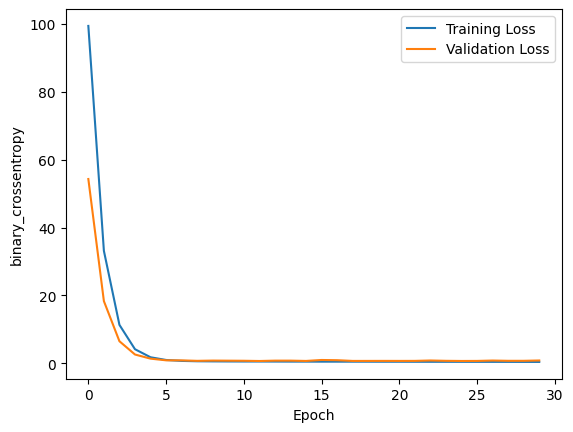

In [ ]:
model= LSTM_Model
history = trainner(dataset_name = 'ResNet',model_name = 'LSTM',dataset_path = DATASET_PATH,train_model = model,size_batch= 32, x_train=x_train_shuffled,y_train=y_train_shuffled,x_test= x_test,y_test=y_test,x_val = x_val_shuffled,y_val = y_val_shuffled)

<!-- tuning 1: batch_size = 32, lstm_layers= 1, optimizer = Adam  
tuning 2: lstm_units = 64, l2_reg 不确定，dropout = 0.2/mean=0.16  
tuning 3: epoch = 50, learning rate = 0.001
tuning 4: l2_reg = 0,1,dropout rate = 0/0.25 -->

In [ ]:
# filepath = DATASET_PATH / GRU-checkpoints/ ResNet
model = LSTM_Model()
model.load_weights("/content/drive/MyDrive/capstone/dataset/LSTM-checkpoints/ResNet")
loss,acc,auc = model.evaluate(x_test,y_test.astype(int))
print('the loss of LSTM is:',loss)
print('the acc of LSTM is:',acc)
print('the auc of LSTM is:',auc)

74/74 [==============================] - 2s 7ms/step - loss: 0.6728 - acc: 0.7309 - auc: 0.8108
the loss of LSTM is: 0.6728359460830688
the acc of LSTM is: 0.7308506369590759
the auc of LSTM is: 0.8107993006706238


In [ ]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
  y = TPR - FPR
  Youden_index = np.argmax(y)  # Only the first occurrence is returned.
  optimal_threshold = threshold[Youden_index]
  point = [FPR[Youden_index], TPR[Youden_index]]
  return optimal_threshold, point

y_pred = model.predict(x_test)
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test.astype(int), y_pred)
optimal_threshold = Find_Optimal_Cutoff(tpr,fpr,threshold)[0]
print("optimal threshold is", optimal_threshold)

74/74 [==============================] - 1s 6ms/step
optimal threshold is 0.49500626


74/74 [==============================] - 0s 5ms/step


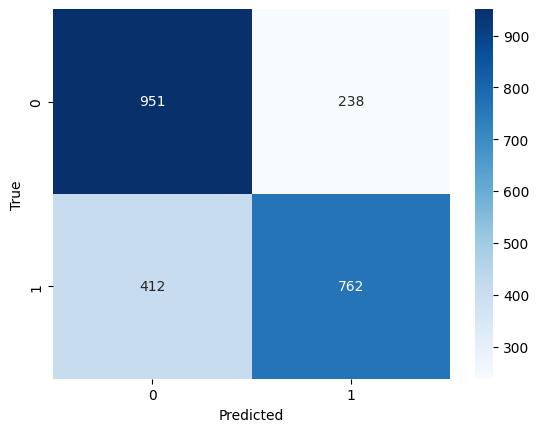

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix  

y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(y_test.astype(int), y_pred_binary)

# 可视化混淆矩阵
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

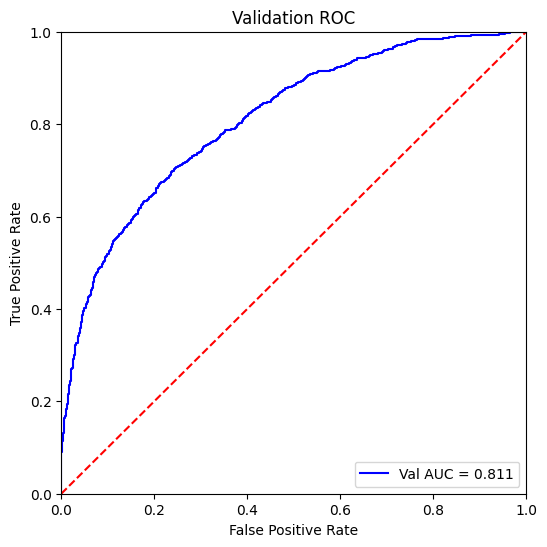

In [ ]:
import sklearn
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test.astype(int), y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
patient_id = list(patient_dict_ResNet.keys())
train_id,test_id_1 = train_test_split(patient_id,train_size=0.7,random_state=42) # train:test:validation = 80% : 20% : 80%*20%= 70%：17% 13%
test_dic ={}
for id in test_id_1:
  x_test_lst = np.array([item[0]  for item in patient_dict_ResNet[id]])[:,:-1,:]
  y_test_lst = np.array([item[1]  for item in patient_dict_ResNet[id]])
  test_dic[id] = (x_test_lst,np.unique(y_test_lst))

In [ ]:
# correct_pred = 0
# result_LSTM = []
# for id in test_dic.keys():
#   x_test_temp = test_dic[id][0]
#   y_test_temp = test_dic[id][1].astype(int)
#   y = model.predict(x_test_temp)
#   res = [label for label in y if label >= best_threshold]
#   rate = len(res) / len(x_test_temp)
#   result_LSTM.append((rate,y_test_temp))

In [ ]:
correct_pred = 0
for id in test_dic.keys():
  x_test_temp = test_dic[id][0]
  y_test_temp = test_dic[id][1].astype(int)
  y = model.predict(x_test_temp)
  res = [label for label in y if label >= 0.5]
  rate = len(res) / len(x_test_temp)
  if rate >= 0.5: y = 1
  else: y = 0
  if y == y_test_temp:
    correct_pred += 1

print('accuracy is', correct_pred/len(test_dic))

3/3 [==============================] - 0s 5ms/step
accuracy is 0.7619047619047619


### 3. Tuning hyperparameters

In [ ]:
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# define the grid spaces  5*100
param_grid = {
    # 'lstm_layers':[1,3,5], 
    'learning_rate': np.linspace(0,0.001,5),
    # 'batch_size': [32,64],
    'l2_reg': np.linspace(0,1,20), 
    # 'optimizer':['Adam','SGD'],
    # 'dropout_rate': np.linspace(0,1,5),
    # 'lstm_units': [128,256],
}
model = KerasClassifier(LSTM_Model,lstm_layers=1, lstm_units=128, learning_rate=0.001,l2_reg= 0.0,dropout_rate=0.16,batch_size=32,optimizer = 'SGD',loss='binary_crossentropy')

grid = RandomizedSearchCV(model, param_grid, cv=3, n_iter = 60,verbose = 0 ,refit=True,scoring = 'roc_auc')
grid_result = grid.fit(x_train_shuffled, y_train_shuffled.astype('int').reshape(-1,1))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

347/347 [==============================] - 4s 7ms/step - loss: 0.6595 - acc: 0.6525 - auc: 0.6982
Best: 0.752019 using {'learning_rate': 0.001, 'l2_reg': 0.15789473684210525}
0.709775 (0.003753) with: {'learning_rate': 0.0005, 'l2_reg': 0.3684210526315789}
0.738514 (0.007638) with: {'learning_rate': 0.00075, 'l2_reg': 0.3684210526315789}
0.499477 (0.023405) with: {'learning_rate': 0.0, 'l2_reg': 0.894736842105263}
0.736898 (0.003733) with: {'learning_rate': 0.001, 'l2_reg': 0.894736842105263}
0.512624 (0.046418) with: {'learning_rate': 0.0, 'l2_reg': 0.7894736842105263}
0.684967 (0.012041) with: {'learning_rate': 0.00025, 'l2_reg': 1.0}
0.665181 (0.012385) with: {'learning_rate': 0.00025, 'l2_reg': 0.05263157894736842}
0.737126 (0.013742) with: {'learning_rate': 0.001, 'l2_reg': 0.3157894736842105}
0.672103 (0.017845) with: {'learning_rate': 0.00025, 'l2_reg': 0.2631578947368421}
0.707103 (0.002802) with: {'learning_rate': 0.0005, 'l2_reg': 0.5789473684210527}
0.725344 (0.007763) with:

Best: 0.788678 using {'optimizer': 'Adam', 'lstm_layers': 1, 'l2_reg': 0.05, 'dropout_rate': 0, 'batch_size': 32} 
可确定：layers=1,batch_size = 32

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

# define the grid spaces  10*2*3*3 = 180

param_grid = {
    'l2_reg': np.linspace(0,1,10), 
    'optimizer':['Adam','SGD'],
    'dropout_rate':[0,0.2,0.4],
    'lstm_units': [64,128,256],
}
model = KerasClassifier(LSTM_Model,lstm_layers=1, lstm_units=64, learning_rate=0.01,l2_reg= 0.0,dropout_rate=0.0,batch_size=32,optimizer = 'SGD',loss='binary_crossentropy')

grid = RandomizedSearchCV(model, param_grid, cv=3, n_iter = 100,verbose = 0 ,refit=True,scoring = 'roc_auc')
grid_result = grid.fit(x_train_shuffled, y_train_shuffled.astype('int').reshape(-1,1))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: ignored

In [ ]:
df = pd.DataFrame(grid_result.cv_results_)
params = list(df.loc[0,'params'].keys())
res = [] #[array_optimizer  ]
for param in params:
  res.append(list(df['params'].apply(lambda x: x[param])))

res.append(list(df['split0_test_score']))
res.append(list(df['split1_test_score']))
res.append(list(df['split2_test_score']))
res.append(list(df['mean_test_score']))
res.append(list(df['std_test_score']))
res.append(list(df['rank_test_score']))
df_temp = pd.DataFrame(res)
df_new = df_temp.T
df_new.columns = params + list(df.loc[:,'split0_test_score':])

In [ ]:
df_new = df_new.sort_values(by = 'rank_test_score')
df_new.head()

,l2_reg,learning_rate,optimizer,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
28,0.075,0.01,Adam,0.764588,0.784892,0.774718,0.774733,0.008289,1
13,0.025,0.01,SGD,0.769345,0.778728,0.767297,0.77179,0.004977,2
37,0.1,0.01,SGD,0.764843,0.777791,0.764536,0.769057,0.006177,3
35,0.1,0.001,SGD,0.761419,0.775981,0.768453,0.768617,0.005946,4
19,0.05,0.001,SGD,0.758304,0.783637,0.762962,0.768301,0.01101,5


In [ ]:
df_new.to_csv(DATASET_PATH/"tuning5_Transformer.csv")

Best: 0.804275 using {'optimizer': 'Adam', 'lstm_units': 64, 'l2_reg': 0.1111111111111111, 'dropout_rate': 0}
可确定lstm_units为64

In [ ]:
df = pd.read_csv(DATASET_PATH/"tuning2_LSTM.csv")
np.mean(df[:10]['l2_reg'])
# np.mean(df[:10]['dropout_rate'])


0.4666666666666666

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import numpy as np
# from tensorflow.keras import callbacks


# 定义网格搜索的参数空间
param_grid = {
    'learning_rate':[0.001,0.01,0.1],
    'epochs': [50,100,200],
}

model = KerasClassifier(LSTM_Model, lstm_layers=1, lstm_units=64, learning_rate=0.001, dropout_rate= 0.14, l2_reg=0.47, epochs=50, loss='binary_crossentropy')

# 定义网格搜索对象
grid = GridSearchCV(model, param_grid, cv=3, verbose=0, refit=True, scoring='roc_auc')
# 执行网格搜索
grid_result = grid.fit(x_train_shuffled, y_train_shuffled.astype('int').reshape(-1, 1))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.882868 using {'epochs': 50, 'learning_rate': 0.001}

# Model: Transformer

### Transformer
class:  
- PositionalEmbedding: position embedding
- TransformerEncoder:  
  + position embedding
  + Multi head attentions
  + layer normalization 
- Transformer_Model


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
import math

import six
import tensorflow as tf
from einops.layers.tensorflow import Rearrange

def gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + tf.tanh(
        (math.sqrt(2 / math.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf


def get_activation(identifier):
    """Maps a identifier to a Python function, e.g., "relu" => `tf.nn.relu`.
    It checks string first and if it is one of customized activation not in TF,
    the corresponding activation will be returned. For non-customized activation
    names and callable identifiers, always fallback to tf.keras.activations.get.
    Args:
        identifier: String name of the activation function or callable.
    Returns:
        A Python function corresponding to the activation function.
    """
    if isinstance(identifier, six.string_types):
        name_to_fn = {"gelu": gelu}
        identifier = str(identifier).lower()
        if identifier in name_to_fn:
            return tf.keras.activations.get(name_to_fn[identifier])
    return tf.keras.activations.get(identifier)

class Residual(tf.keras.Model):#   Residual (PreNorm(Attention(dim, heads = heads)))
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def call(self, x):
        return self.fn(x) + x 


class PreNorm(tf.keras.Model): #   PreNorm(Attention(dim, heads = heads))  fn = Attention(dim,heads = heads)


    def __init__(self, fn):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization()
        self.fn = fn

    def call(self, x):
        return self.norm(self.fn(x))



class FeedForward(tf.keras.Model):

    def __init__(self, dim, hidden_dim,l2_reg):
        super().__init__()
        self.net = tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(dim,kernel_regularizer=tf.keras.regularizers.l2(l2_reg))])

    def call(self, x):
        return self.net(x)

class Attention(tf.keras.Model):
    def __init__(self, dim, heads = 8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = tf.keras.layers.Dense(dim * 3, use_bias=False)
        self.to_out = tf.keras.layers.Dense(dim)

        self.rearrange_qkv = Rearrange('b n (qkv h d) -> qkv b h n d', qkv = 3, h = self.heads)
        self.rearrange_out = Rearrange('b h n d -> b n (h d)')

    def call(self, x):
        qkv = self.to_qkv(x)
        qkv = self.rearrange_qkv(qkv)
        q = qkv[0]
        k = qkv[1]
        v = qkv[2]

        dots = tf.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = tf.nn.softmax(dots,axis=-1)

        out = tf.einsum('bhij,bhjd->bhid', attn, v)
        out = self.rearrange_out(out)
        out =  self.to_out(out)
        return out

class Transformer(tf.keras.Model):

    def __init__(self, dim, depth, heads, mlp_dim,l2_reg):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend([
                PreNorm(Residual(Attention(dim, heads = heads))),
                PreNorm(PreNorm(FeedForward(dim, mlp_dim,l2_reg)))
            ])
            # attetion  -> x+ attention -> layernorm(x) 

        self.net = tf.keras.Sequential(layers)
    def call(self, x):
        return self.net(x)

class ViT(tf.keras.Model):

    def __init__(self, *, seq_len = MAX_SEQ_LENGTH, num_classes=1, dim=NUM_FEATURES, stack_num=1, heads=2, mlp_dim= 256,l2_reg=0):
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.position_embedding = layers.Embedding(input_dim= seq_len + 1,output_dim= dim) # embedding


        self.cls_token = self.add_weight("cls_token",
                                         shape=[1,1,dim],
                                         initializer=tf.keras.initializers.Zeros(),
                                         dtype=tf.float32,
                                         trainable = True)


        self.transformer = Transformer(dim, stack_num, heads, mlp_dim,l2_reg)

        self.to_cls_token = tf.identity

        self.mlp_head = tf.keras.Sequential([tf.keras.layers.Dense(mlp_dim, activation=get_activation('gelu')),
                                        tf.keras.layers.Dense(num_classes,activation= 'sigmoid',kernel_regularizer=tf.keras.regularizers.l2(l2_reg))])
        self.pooling_layer = tf.keras.layers.GlobalAveragePooling1D()

    @tf.function
    def call(self, x):
        shapes = tf.shape(x)

        # cls_tokens = tf.broadcast_to(self.cls_token,(shapes[0],1,self.dim))
        # x = tf.concat((cls_tokens, x), axis=1)

        positions = tf.range(start=0, limit=self.seq_len , delta=1)
        embedded_positions = self.position_embedding(positions)
        x += embedded_positions
        x = self.transformer(x)
        # print(x.shape)
        x =  self.pooling_layer(x)


        return self.mlp_head(x)

In [ ]:
def Transformer_Model(stack_num=1,heads=4,mlp_dim=256,learning_rate=0.01,l2_reg=0.075):
  acc = keras.metrics.BinaryAccuracy(name = 'acc')
  auc = keras.metrics.AUC(name = 'auc') 
  model = keras.Sequential()
  model.add(layers.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES)))
  model.add(ViT(l2_reg=l2_reg,stack_num=stack_num, heads=heads, mlp_dim= mlp_dim))
  optimizer = optimizers.SGD(learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics= [acc,auc])
  return model

Epoch 1/30


346/347 [============================>.] - ETA: 0s - loss: 19.8511 - acc: 0.6729 - auc: 0.7258
Epoch 1: val_auc improved from -inf to 0.67008, saving model to /content/drive/MyDrive/capstone/dataset/Transformer_without_cls-checkpoints/ResNet
347/347 [==============================] - 16s 24ms/step - loss: 19.8457 - acc: 0.6730 - auc: 0.7260 - val_loss: 11.5919 - val_acc: 0.6063 - val_auc: 0.6701
Epoch 2/30
345/347 [============================>.] - ETA: 0s - loss: 7.3236 - acc: 0.7475 - auc: 0.8183
Epoch 2: val_auc improved from 0.67008 to 0.75710, saving model to /content/drive/MyDrive/capstone/dataset/Transformer_without_cls-checkpoints/ResNet
347/347 [==============================] - 5s 15ms/step - loss: 7.3131 - acc: 0.7477 - auc: 0.8186 - val_loss: 4.4376 - val_acc: 0.6885 - val_auc: 0.7571
Epoch 3/30
347/347 [==============================] - ETA: 0s - loss: 2.8965 - acc: 0.7738 - auc: 0.8464
Epoch 3: val_auc did not improve from 0.75710
347/347 [==============================] 

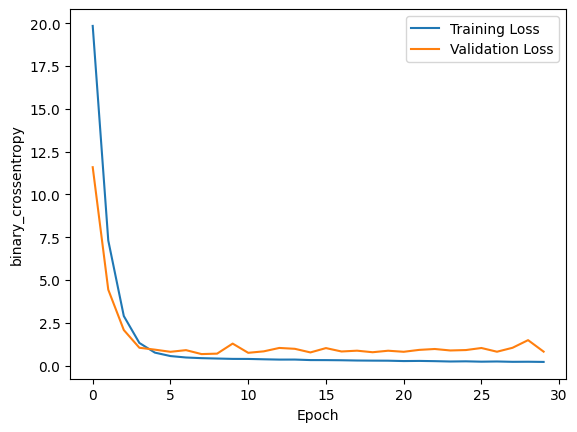

In [ ]:
model= Transformer_Model
history = trainner(dataset_name = 'ResNet',model_name = 'Transformer_without_cls',dataset_path = DATASET_PATH,train_model = model,size_batch= 32, x_train=x_train_shuffled,y_train=y_train_shuffled,x_test= x_test,y_test=y_test,x_val = x_val_shuffled,y_val = y_val_shuffled)

In [ ]:
# filepath = DATASET_PATH / GRU-checkpoints/ ResNet
model = Transformer_Model()
model.load_weights("/content/drive/MyDrive/capstone/dataset/Transformer_without_cls-checkpoints/ResNet")
loss,acc,auc = model.evaluate(x_test,y_test.astype(int))
print('the loss of Transformer is:',loss)
print('the acc of Transformer is:',acc)
print('the auc of Transformer is:',auc)

74/74 [==============================] - 1s 10ms/step - loss: 1.0891 - acc: 0.6919 - auc: 0.8146
the loss of Transformer is: 1.089111566543579
the acc of Transformer is: 0.6919170618057251
the auc of Transformer is: 0.8145802021026611


the loss of Transformer is: 0.9474249482154846  
the acc of Transformer is: 0.6792213320732117  
the auc of Transformer is: 0.8244343996047974 SGD  
learning rate:0.001 , l2_reg = 0.8 :过拟合减弱
the loss of Transformer is: 0.7328461408615112  
the acc of Transformer is: 0.6606009602546692  
the auc of Transformer is: 0.8279945254325867  
l2_reg=0.075 lr = 0.01
the loss of Transformer is: 0.5572596788406372  
the acc of Transformer is: 0.7621667385101318  
the auc of Transformer is: 0.8507499098777771

stack= 3 head= 8 l1= 0.2(?) 
the loss of Transformer is: 0.6400132775306702
the acc of Transformer is: 0.7316970229148865
the auc of Transformer is: 0.8145722150802612




In [ ]:
import sklearn
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.astype(int), y_pred)
d = np.sqrt((1 - tpr)**2 + fpr**2)
idx = np.argmin(d)

# 计算最优的阈值
best_threshold = thresholds[idx]
print('the best threshold is',best_threshold)

the best threshold is 0.3518493


74/74 [==============================] - 1s 8ms/step


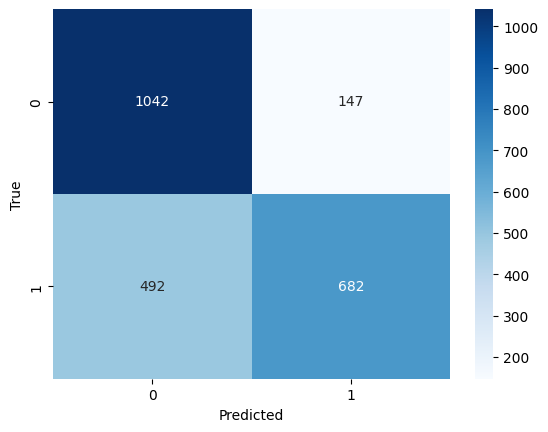

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix  

y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= best_threshold).astype(int)

cm = confusion_matrix(y_test.astype(int), y_pred_binary)

# 可视化混淆矩阵
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
correct_pred = 0
for id in test_dic.keys():
  x_test_temp = test_dic[id][0]
  y_test_temp = test_dic[id][1].astype(int)
  y = model.predict(x_test_temp)
  res = [label for label in y if label >= 0.5]
  rate = len(res) / len(x_test_temp)
  if rate >= 0.5: y = 1
  else: y = 0
  if y == y_test_temp:
    correct_pred += 1

print('accuracy is', correct_pred/len(test_dic))

3/3 [==============================] - 0s 7ms/step
accuracy is 0.7936507936507936


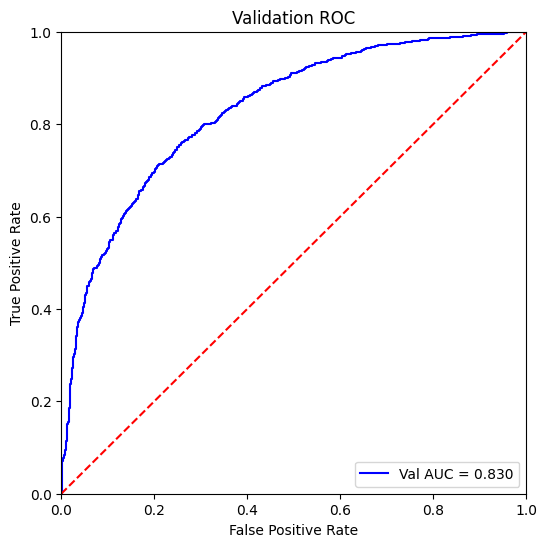

In [ ]:
import sklearn
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test.astype(int), y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# define the grid spaces
param_grid = {
    # 'heads':range(2,9,2), # 2 4 6 8
    # 'stack_num': range(1,7,2),
    # 'batch_size': [32,64],
    'l2_reg': np.linspace(0,0.1,5),
    'optimizer':['Adam','SGD'],
    # 'mlp_dim':[64,128,256]
    'learning_rate':[0.0005,0.001,0.01,0.1],
    # 'epochs':[50.100]
}
model = KerasClassifier(Transformer_Model,heads=4,stack_num=1,learning_rate=0.0001,l2_reg =0.1,mlp_dim=256,optimizer = 'SGD',loss='binary_crossentropy')
# load the data: use the 1st fold to do the grid search(ResNet)

# 定义网格搜索对象
grid = GridSearchCV(model, param_grid, cv=3, verbose = 0 ,refit=True,scoring = 'roc_auc')
# 执行网格搜索
grid_result = grid.fit(x_train_shuffled, y_train_shuffled.astype('int').reshape(-1,1))
best_estimator = grid.best_estimator_
# 输出最佳超参数组合和最小验证误差
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

347/347 [==============================] - 7s 13ms/step - loss: 0.7338 - acc: 0.6448 - auc: 0.6894
Best: 0.774733 using {'l2_reg': 0.07500000000000001, 'learning_rate': 0.01, 'optimizer': 'Adam'}
0.735724 (0.007535) with: {'l2_reg': 0.0, 'learning_rate': 0.0005, 'optimizer': 'Adam'}
0.749033 (0.008343) with: {'l2_reg': 0.0, 'learning_rate': 0.0005, 'optimizer': 'SGD'}
0.768267 (0.012308) with: {'l2_reg': 0.0, 'learning_rate': 0.001, 'optimizer': 'Adam'}
0.762150 (0.006416) with: {'l2_reg': 0.0, 'learning_rate': 0.001, 'optimizer': 'SGD'}
0.762920 (0.013147) with: {'l2_reg': 0.0, 'learning_rate': 0.01, 'optimizer': 'Adam'}
0.767231 (0.006777) with: {'l2_reg': 0.0, 'learning_rate': 0.01, 'optimizer': 'SGD'}
0.471150 (0.048860) with: {'l2_reg': 0.0, 'learning_rate': 0.1, 'optimizer': 'Adam'}
0.495580 (0.025470) with: {'l2_reg': 0.0, 'learning_rate': 0.1, 'optimizer': 'SGD'}
0.752714 (0.005843) with: {'l2_reg': 0.025, 'learning_rate': 0.0005, 'optimizer': 'Adam'}
0.737455 (0.017878) with: 

In [ ]:
correct_pred = 0
for id in test_dic.keys():
  x_test = test_dic[id][0]
  y_test = test_dic[id][1].astype(int)
  y = model.predict(x_test)
  res = [label for label in y if label >= best_threshold]
  rate = len(res) / len(x_test)
  print(rate,y_test)
  if rate >= 0.5:
    y = 1
  else:
    y = 0
  if y == y_test:
    print("correct")
    correct_pred += 1
  else:
    print('uncorrect')
print('accuracy is', correct_pred/len(test_dic))

2/2 [==============================] - 0s 210ms/step
0.16666666666666666 [0]
correct
3/3 [==============================] - 1s 201ms/step
0.8837209302325582 [1]
correct
2/2 [==============================] - 1s 286ms/step
0.21311475409836064 [0]
correct
3/3 [==============================] - 1s 350ms/step
0.9230769230769231 [1]
correct
6/6 [==============================] - 1s 156ms/step
0.05113636363636364 [0]
correct
3/3 [==============================] - 0s 115ms/step
0.36619718309859156 [1]
uncorrect
3/3 [==============================] - 1s 163ms/step
0.14285714285714285 [0]
correct
3/3 [==============================] - 1s 163ms/step
0.18181818181818182 [1]
uncorrect
2/2 [==============================] - 0s 113ms/step
0.05454545454545454 [0]
correct
3/3 [==============================] - 0s 130ms/step
0.863013698630137 [1]
correct
3/3 [==============================] - 1s 160ms/step
0.5555555555555556 [1]
correct
3/3 [==============================] - 0s 110ms/step
0.77333333333

In [ ]:
model = LSTM_Model()
result_LSTM = []
model.load_weights("/content/drive/MyDrive/capstone/dataset/LSTM-checkpoints/ResNet")
correct_pred = 0
for id in test_dic.keys():
  x_test = test_dic[id][0]
  y_test = test_dic[id][1].astype(int)
  y = model.predict(x_test)
  res = [label for label in y if label >= best_threshold]
  rate = len(res) / len(x_test)

In [ ]:
rate_LSTM = [item[0] for item in result_LSTM]
rate_Transformer = [item[0] for item in result_Transformer]
real_value  = [int(item[1]) for item in result_Transformer]
df = pd.DataFrame({'LSTM_rate': rate_LSTM, 
                   'Transformer_rate': rate_Transformer, 
                   'real_value': real_value})

In [ ]:
df

,LSTM_rate,Transformer_rate,real_value
0,0.166667,0.166667,0
1,0.860465,0.883721,1
2,0.344262,0.213115,0
3,0.945055,0.923077,1
4,0.232955,0.051136,0
...,...,...,...
58,0.142857,0.114286,0
59,0.697674,0.674419,0
60,0.938462,0.953846,1
61,0.075758,0.000000,0


In [ ]:
df['diff_LSTM'] = df['LSTM_rate'] - df['real_value']
df['diff_Transformer'] = df['Transformer_rate'] - df['real_value']
print(np.mean(df['diff_LSTM'])**2)
print(np.mean(df['diff_Transformer']**2))
print(np.mean(df['diff_LSTM']))
print(np.mean(df['diff_Transformer']))
# （预测值 - （1，0））平方和更大：
# 差值更小，则为1的时候

0.0020950447024058187
0.14525203248622576
-0.04577165828769828
-0.07779120969508324


In [ ]:
result_LSTM

[(0.2777777777777778, array([0])),
 (0.9534883720930233, array([1])),
 (0.4426229508196721, array([0])),
 (0.967032967032967, array([1])),
 (0.3465909090909091, array([0])),
 (0.6056338028169014, array([1])),
 (0.37362637362637363, array([0])),
 (0.38636363636363635, array([1])),
 (0.18181818181818182, array([0])),
 (0.863013698630137, array([1])),
 (0.8, array([1])),
 (0.8533333333333334, array([1])),
 (0.9659090909090909, array([1])),
 (0.5753424657534246, array([1])),
 (0.26153846153846155, array([0])),
 (0.11392405063291139, array([0])),
 (0.7922077922077922, array([1])),
 (0.4186046511627907, array([0])),
 (0.9733333333333334, array([1])),
 (0.19607843137254902, array([0])),
 (0.5, array([0])),
 (0.38235294117647056, array([0])),
 (0.3584905660377358, array([1])),
 (0.9113924050632911, array([1])),
 (0.963855421686747, array([1])),
 (0.5064935064935064, array([1])),
 (0.5769230769230769, array([0])),
 (0.4936708860759494, array([1])),
 (0.38596491228070173, array([0])),
 (0.784810

In [ ]:
# Position Embedding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim,stack_head, **kwargs):
        super().__init__(**kwargs)
        self.stack_head = stack_head
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,output_dim=output_dim) # embedding
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        if not self.stack_head: return inputs
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1) #tensor: range(0,length_frames,1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions
       

    def compute_mask(self, inputs, mask=None): # masking
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self,num_heads, hidden_size, dropout_rate,stack_head):
        super().__init__()
        self.embed_dim = NUM_FEATURES
        self.pos_embedding = PositionalEmbedding(sequence_length = MAX_SEQ_LENGTH, output_dim = NUM_FEATURES,stack_head= stack_head)

        self.attention = layers.MultiHeadAttention(num_heads = num_heads, key_dim = self.embed_dim, dropout = 0.3)
        self.layernorm = layers.LayerNormalization()
        
        # feedforward
        self.ffn_dense1 = layers.Dense(hidden_size, activation="relu")
        self.ffn_dense2 = layers.Dense(self.embed_dim, activation="relu")
        self.ffn_dropout = layers.Dropout(dropout_rate)
        

    def call(self,x): #input (None,28,1024)
        p_embedding = self.pos_embedding( x) # positional embedding
        attn_output = self.attention(query = p_embedding, value = p_embedding, key = p_embedding, attention_mask=True)
        attn_output = self.layernorm(x + attn_output)
        ffn_output = self.ffn_dense1(attn_output)
        ffn_output = self.ffn_dense2(ffn_output)
        ffn_output = self.ffn_dropout(ffn_output)
        output = self.layernorm(attn_output + ffn_output)
        return output

In [ ]:
def Transformer_Model(learning_rate = 0.0001,num_heads=2,encoder_stacks= 1):
    acc = tf.keras.metrics.BinaryAccuracy()
    auc = tf.keras.metrics.AUC(name = 'auc')
    metrics_list = [keras.metrics.BinaryAccuracy(),keras.metrics.Precision()]
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(MAX_SEQ_LENGTH, NUM_FEATURES)))
    for stack in range(encoder_stacks):
      if stack == 0:
        model.add(TransformerEncoder(num_heads = num_heads, hidden_size =64, dropout_rate= 0.02,stack_head = True))
      else:
        model.add(TransformerEncoder(num_heads = num_heads, hidden_size =64, dropout_rate= 0.02,stack_head = False))

    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    model.compile(optimizer=optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics= [acc,auc])
    return model


In [ ]:
model = Transformer_Model(learning_rate = 0.001,num_heads=2,encoder_stacks=2)
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder (Transf  (None, 28, 1024)         8558656   
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  (None, 28, 1024)         8529984   
 sformerEncoder)                                                 
                                                                 
 global_max_pooling1d (Globa  (None, 1024)             0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_30 (Dense)            (None, 1)                 1025      
                                                     

#### 2. Train and evaluate Transformer 

**On ResNet Dataset**

In [ ]:
model= Transformer_Model
ResNet_loss, ResNet_acc, ResNet_auc = K_fold_validation(K = 5, dataset_name ='ResNet',model_name = 'Transformer',train_model = model)

Processing fold 1:
Epoch 1/15
393/393 [==============================] - ETA: 0s - loss: 0.6664 - binary_accuracy: 0.6458 - auc: 0.6917
Epoch 1: val_auc improved from -inf to 0.75662, saving model to /content/drive/MyDrive/capstone/dataset/Transformer-K-fold-checkpoints/ResNet-K-fold_1
393/393 [==============================] - 295s 745ms/step - loss: 0.6664 - binary_accuracy: 0.6458 - auc: 0.6917 - val_loss: 0.7078 - val_binary_accuracy: 0.6206 - val_auc: 0.7566 - lr: 1.0000e-04
Epoch 2/15
393/393 [==============================] - ETA: 0s - loss: 0.5635 - binary_accuracy: 0.7145 - auc: 0.7818
Epoch 2: val_auc improved from 0.75662 to 0.76274, saving model to /content/drive/MyDrive/capstone/dataset/Transformer-K-fold-checkpoints/ResNet-K-fold_1
393/393 [==============================] - 262s 666ms/step - loss: 0.5635 - binary_accuracy: 0.7145 - auc: 0.7818 - val_loss: 0.5735 - val_binary_accuracy: 0.6852 - val_auc: 0.7627 - lr: 1.0000e-04
Epoch 3/15
393/393 [==========================

In [ ]:
print("the ResNet's Transformer loss score of the K-folder is %f"%(ResNet_loss))
print("the ResNet's Transformer accuracy score of the K-folder is %f"%(ResNet_acc))
print("the ResNet's Transformer auc score of the K-folder is %f"%(ResNet_auc))

the ResNet's Transformer loss score of the K-folder is 0.639215
the ResNet's Transformer accuracy score of the K-folder is 0.688979
the ResNet's Transformer auc score of the K-folder is 0.753819


**On VGG Dataset**

In [ ]:
model= Transformer_Model
Vgg_loss, Vgg_acc, Vgg_auc = K_fold_validation(K =5 ,dataset_name = 'VGG',model_name = 'Transformer' ,train_model = model)

Processing fold 1:
Epoch 1/15
392/393 [============================>.] - ETA: 0s - loss: 0.5979 - binary_accuracy: 0.6845 - auc: 0.7490
Epoch 1: val_auc improved from -inf to 0.69790, saving model to /content/drive/MyDrive/capstone/dataset/LSTM-K-fold-checkpoints/VGG-K-fold_1
393/393 [==============================] - 21s 42ms/step - loss: 0.5979 - binary_accuracy: 0.6842 - auc: 0.7489 - val_loss: 0.7175 - val_binary_accuracy: 0.6440 - val_auc: 0.6979 - lr: 0.0010
Epoch 2/15
393/393 [==============================] - ETA: 0s - loss: 0.5048 - binary_accuracy: 0.7518 - auc: 0.8310
Epoch 2: val_auc improved from 0.69790 to 0.73329, saving model to /content/drive/MyDrive/capstone/dataset/LSTM-K-fold-checkpoints/VGG-K-fold_1
393/393 [==============================] - 15s 37ms/step - loss: 0.5048 - binary_accuracy: 0.7518 - auc: 0.8310 - val_loss: 0.8709 - val_binary_accuracy: 0.5775 - val_auc: 0.7333 - lr: 0.0010
Epoch 3/15
393/393 [==============================] - ETA: 0s - loss: 0.4690 -

In [ ]:
print("the VGG's LSTM loss score of the K-folder is %f"%(Vgg_loss))
print("the VGG's LSTM accuracy score of thae K-folder is %f"%(Vgg_acc))
print("the VGG's LSTM auc score of the K-folder is %f"%(Vgg_auc))

the VGG's LSTM loss score of the K-folder is 0.735091
the VGG's LSTM accuracy score of thae K-folder is 0.702211
the VGG's LSTM auc score of the K-folder is 0.768914


**On ViT Dataset**

In [ ]:
# model= GRU_Model()
# ViT_loss, ViT_acc, ViT_auc = K_fold_validation(dataset_name = 'ViT',train_model = model)

In [ ]:
# print("the ViT's GRU loss score of the K-folder is %f"%(ViT_loss))
# print("the ViT's GRU accuracy score of thae K-folder is %f"%(ViT_acc)
# print("the ViT's GRU auc score of the K-folder is %f"%(ViT_auc)